In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import statsmodels.api as sm
data = pd.read_csv('/workspaces/minor_hw/Untitled spreadsheet - Данные 2006-2017.csv') # read csv file
data

,region,январь,февраль,январь-февраль,март,январь-март,апрель,январь-апрель,май,январь-май,...,январь-август.10,сентябрь.10,январь-сентябрь.10,октябрь.10,январь-октябрь.10,ноябрь.10,январь-ноябрь.10,декабрь.10,январь-декабрь.10,январь.11
0,center,"14,845","16,414","31,259","15,753","47,012","21,803","68,815","9,384","78,199",...,"179,309","31,401","210,710","21,207","231,917","16,157","248,074","15,466","263,540","13,495"
1,north,"4,977","5,898","10,875","7,287","18,162","8,009","26,171","3,888","30,059",...,"71,253","11,942","83,195","8,682","91,877","6,776","98,653","7,112","105,765","5,317"


### 1. Фильтрация и подготовка данных


In [3]:
filtered_columns = [col for col in data.columns if '-' not in col]

# Создаем новый DataFrame c нужными колонками
filtered_data = data[filtered_columns]
df = filtered_data.T.reset_index()
names = df.iloc[0]
df = df[1:]
df.rename(columns=names, inplace=True)

df = df[['center','north']] 
df = df.replace(',', '.', regex=True).apply(pd.to_numeric, errors='coerce')
df.head()

,center,north
1,14.845,4.977
2,16.414,5.898
3,15.753,7.287
4,21.803,8.009
5,9.384,3.888


### 2. Построение графика временных рядов


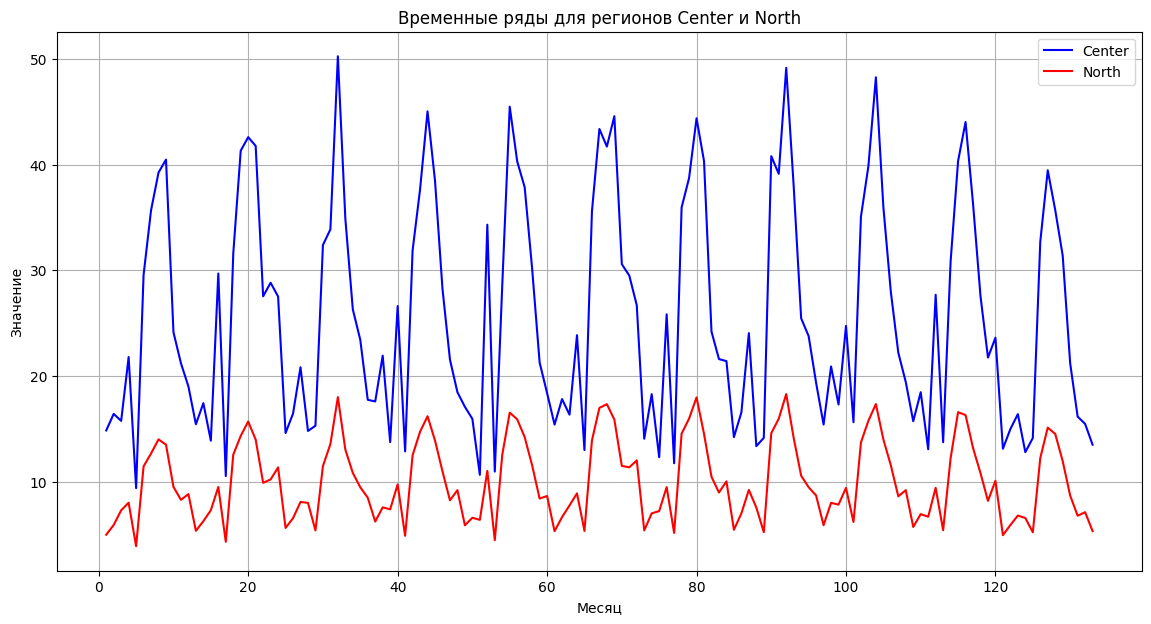

In [4]:

# Построение графиков временных рядов
plt.figure(figsize=(14, 7))
plt.plot(df.index, df['center'], label='Center', color='blue')
plt.plot(df.index, df['north'], label='North', color='red')
plt.xlabel('Месяц')
plt.ylabel('Значение')
plt.title('Временные ряды для регионов Center и North')
plt.legend()
plt.grid(True)
plt.show()

### 3. Анализ автокорреляционной функции (ACF) и частичной автокорреляционной функции (PACF)



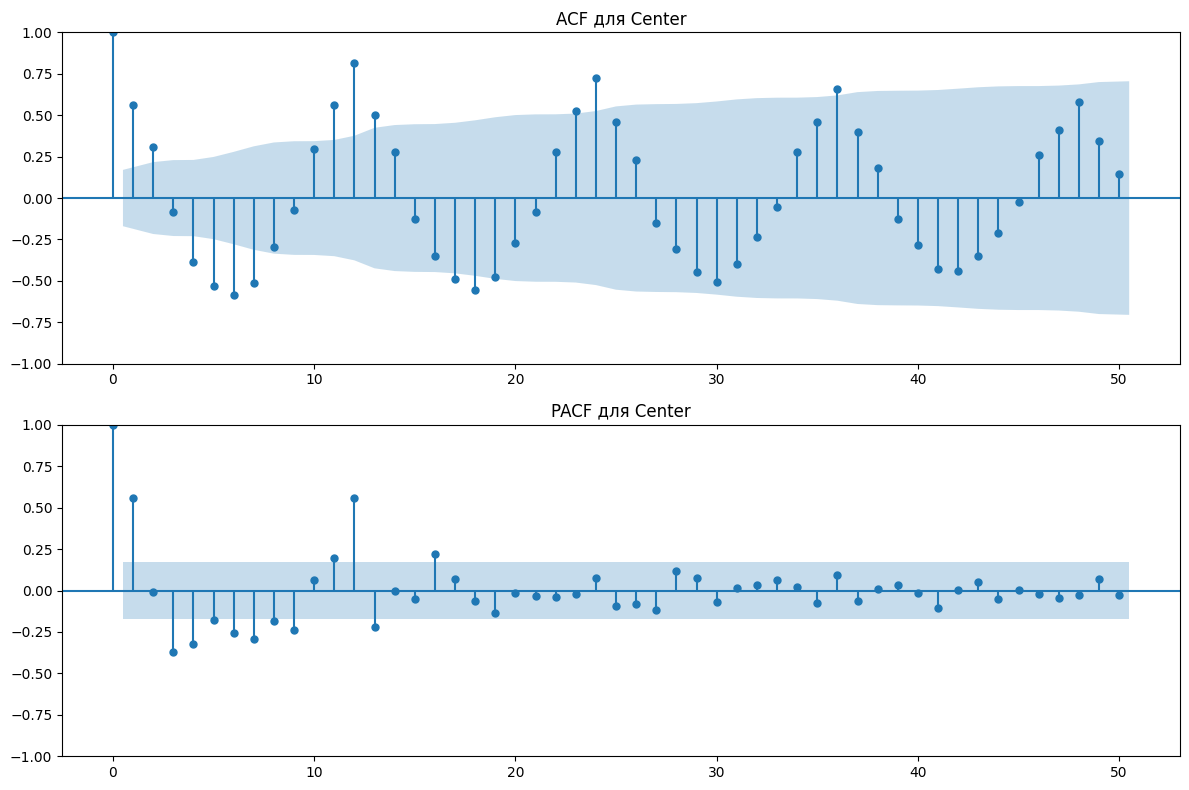

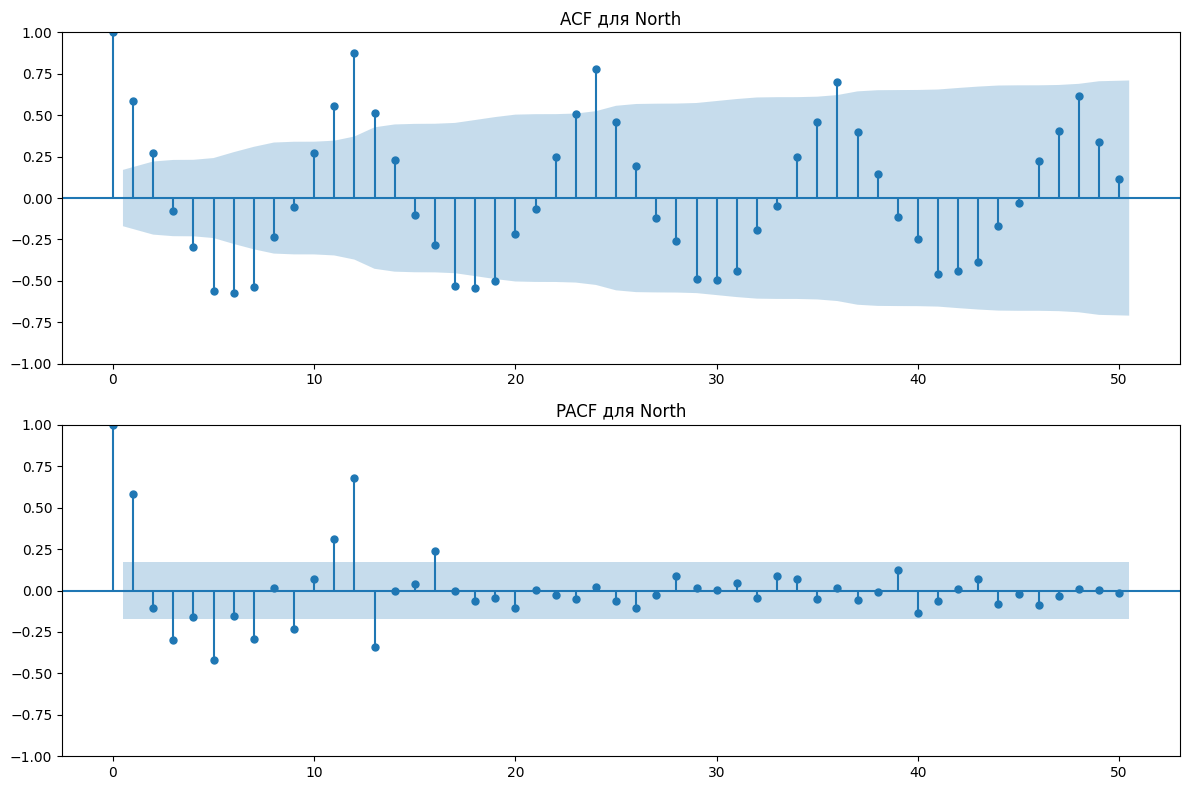

In [5]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Построение ACF и PACF для центра
fig, ax = plt.subplots(2, 1, figsize=(12, 8))
plot_acf(df['center'].dropna(), ax=ax[0], lags=50)
plot_pacf(df['center'].dropna(), ax=ax[1], lags=50)
ax[0].set_title('ACF для Center')
ax[1].set_title('PACF для Center')
plt.tight_layout()
plt.show()

# Построение ACF и PACF для севера
fig, ax = plt.subplots(2, 1, figsize=(12, 8))
plot_acf(df['north'].dropna(), ax=ax[0], lags=50)
plot_pacf(df['north'].dropna(), ax=ax[1], lags=50)
ax[0].set_title('ACF для North')
ax[1].set_title('PACF для North')
plt.tight_layout()
plt.show()

1. Первые несколько лагов (Лаг 1):
   - Автокорреляция на первых нескольких лагах (особенно на лаге 1) очень высокая, что свидетельствует о сильной зависимости значений временного ряда между соседними наблюдениями.

2. Постепенное убывание автокорреляций:
   - Начиная с лага 2, видим постепенное убывание автокорреляций. Это указывает на то, что значения временного ряда все меньше связаны между собой по мере увеличения лага.
   
3. Значения автокорреляций за пределами доверительного интервала:
   - Несколько значений автокорреляции попадают за пределы доверительного интервала, что указывает на статистически значимые автокорреляции.
   - Это может свидетельствовать о наличии сезонности или длинной памяти в данных.

4. Сезонные пики:
   - Примерно каждые 12 лагов появляются пики, что может указывать на наличие сезонности с годовым циклом.

Выводы общие для обеих серий

### 4. Построение периодограммы


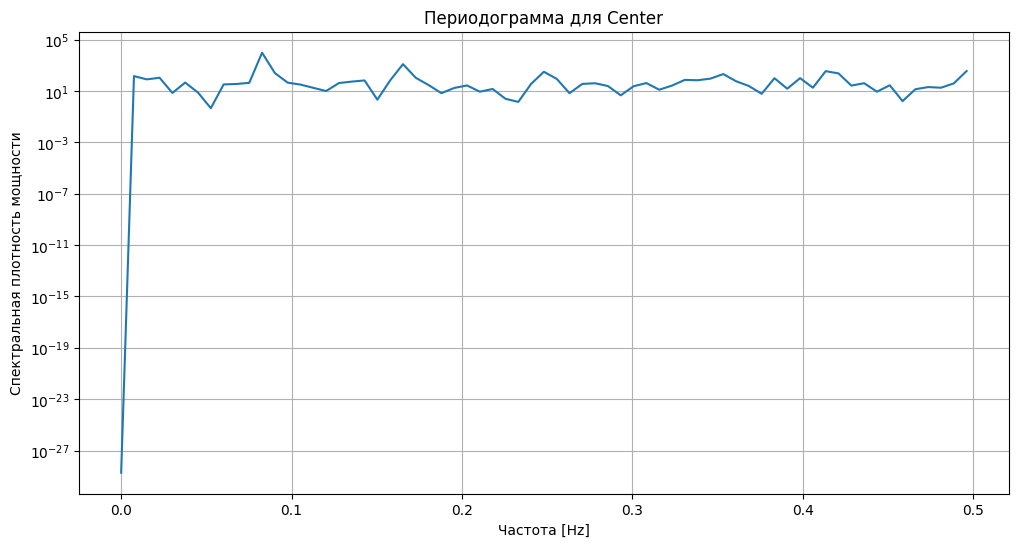

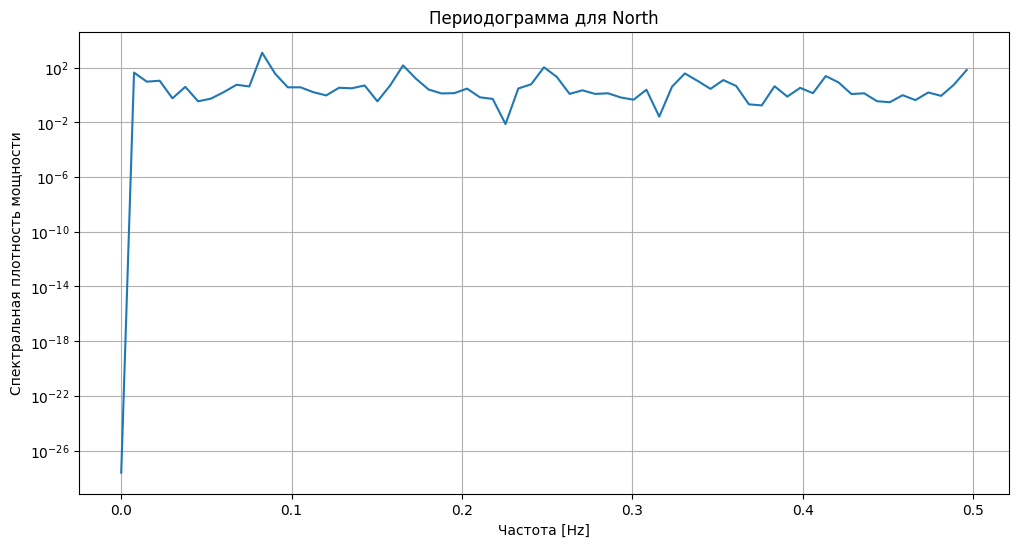

In [6]:
from scipy.signal import periodogram

# Периодограмма для центра
f_center, Pxx_den_center = periodogram(df['center'].dropna())
plt.figure(figsize=(12, 6))
plt.semilogy(f_center, Pxx_den_center)
plt.title('Периодограмма для Center')
plt.xlabel('Частота [Hz]')
plt.ylabel('Спектральная плотность мощности')
plt.grid(True)
plt.show()

# Периодограмма для севера
f_north, Pxx_den_north = periodogram(df['north'].dropna())
plt.figure(figsize=(12, 6))
plt.semilogy(f_north, Pxx_den_north)
plt.title('Периодограмма для North')
plt.xlabel('Частота [Hz]')
plt.ylabel('Спектральная плотность мощности')
plt.grid(True)
plt.show()

In [7]:
# Заменяем запятые на точки и преобразуем данные в числовой формат

# Берем данные по региону "center"
center_series = df['center'].dropna().values

lags = 12

X = np.vstack([center_series[lags - i - 1:-i - 1] for i in range(lags)]).T

Y = center_series[lags:]

print("Размер Y:", Y.shape)
print("Размер X:", X.shape)

if Y.shape[0] == X.shape[0]:
    print("Размеры Y и X совпадают")
else:
    print("Размеры Y и X не совпадают")

# Проверка первых 10 значений Y и X
# print(Y[:10])
# print(X[:10])

Размер Y: (121,)
Размер X: (121, 12)
Размеры Y и X совпадают


In [8]:
import statsmodels.api as sm

def hegy_test(series, seasonal_periods=12, trend=''):
    lags = seasonal_periods
    Y = series[lags:]
    # Формирование регрессоров
    X = np.vstack([series[lags - i - 1:-i - 1] for i in range(lags)]).T
    
    if 'c' in trend:
        X = sm.add_constant(X)

    if 't' in trend:
        trend_array = np.arange(1, len(Y) + 1).reshape(-1, 1)
        X = np.column_stack([X, trend_array])

    if 'd' in trend:
        dummy_array = pd.get_dummies(np.arange(len(Y)) % lags).values
        X = np.column_stack([X, dummy_array[:, 1:]])

    # Проверка на совпадение размеров Y и X
    if Y.shape[0] != X.shape[0]:
        raise ValueError("Mismatch in the number of rows between Y and X")

    # Оценка модели
    model = sm.OLS(Y, X).fit()
    t_stats = model.tvalues
    p_values = model.pvalues

    return t_stats, p_values, model.summary()

# Пример выполнения HEGY-теста
t_stats_no_trend, p_values_no_trend, summary_no_trend = hegy_test(center_series, seasonal_periods=12, trend='')
t_stats_trend, p_values_trend, summary_trend = hegy_test(center_series, seasonal_periods=12, trend='ct')
t_stats_fict_per, p_values_fict_per, summary_fict_per = hegy_test(center_series, seasonal_periods=12, trend='ctd')





In [9]:
print("HEGY Test (без тренда):\n", summary_no_trend)

HEGY Test (без тренда):
                                  OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   0.975
Model:                            OLS   Adj. R-squared (uncentered):              0.973
Method:                 Least Squares   F-statistic:                              359.3
Date:                Thu, 20 Jun 2024   Prob (F-statistic):                    1.06e-81
Time:                        06:14:05   Log-Likelihood:                         -350.94
No. Observations:                 121   AIC:                                      725.9
Df Residuals:                     109   BIC:                                      759.4
Df Model:                          12                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
----------------

In [10]:
print("\nHEGY Test (с трендом):\n", summary_trend)


HEGY Test (с трендом):
                             OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.841
Model:                            OLS   Adj. R-squared:                  0.822
Method:                 Least Squares   F-statistic:                     43.49
Date:                Thu, 20 Jun 2024   Prob (F-statistic):           1.19e-36
Time:                        06:14:05   Log-Likelihood:                -347.34
No. Observations:                 121   AIC:                             722.7
Df Residuals:                     107   BIC:                             761.8
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          9.8676     1

In [11]:
print("\nHEGY Test (с фикт. пер):\n", summary_fict_per)


HEGY Test (с фикт. пер):
                             OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.917
Model:                            OLS   Adj. R-squared:                  0.896
Method:                 Least Squares   F-statistic:                     44.23
Date:                Thu, 20 Jun 2024   Prob (F-statistic):           1.38e-41
Time:                        06:14:05   Log-Likelihood:                -307.91
No. Observations:                 121   AIC:                             665.8
Df Residuals:                      96   BIC:                             735.7
Df Model:                          24                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          2.7501    

### Шаг 3: Пример для данных региона "north"


In [12]:
# Берем данные по региону "north"
north_series = df['north'].dropna().values

# Запуск HEGY-теста для региона "north" (разные модификации)
t_stats_no_trend_north, p_values_no_trend_north, summary_no_trend_north = hegy_test(north_series, seasonal_periods=12, trend='')
t_stats_trend_north, p_values_trend_north, summary_trend_north = hegy_test(north_series, seasonal_periods=12, trend='ct')
t_stats_fict_per_north, p_values_fict_per_north, summary_fict_per_north = hegy_test(north_series, seasonal_periods=12, trend='ctd')

# Вывод результатов
print("HEGY Test (без тренда):\n", summary_no_trend_north)
print("\nHEGY Test (с трендом):\n", summary_trend_north)
print("\nHEGY Test (с фикт. пер):\n", summary_fict_per_north)

HEGY Test (без тренда):
                                  OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   0.989
Model:                            OLS   Adj. R-squared (uncentered):              0.988
Method:                 Least Squares   F-statistic:                              817.8
Date:                Thu, 20 Jun 2024   Prob (F-statistic):                   8.27e-101
Time:                        06:14:05   Log-Likelihood:                         -187.20
No. Observations:                 121   AIC:                                      398.4
Df Residuals:                     109   BIC:                                      431.9
Df Model:                          12                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
----------------

Первоначально оценим модели SARIMA для заданного региона:

1. Модель SARIMA (0,1,1)(0,1,1)12:
   $$
   (1 - B)(1 - B^s)X_t = (1 + \theta_1 B)(1 + \Theta_1 B^s)\varepsilon_t
   $$

2. Модель SARIMA (1,0,0)(1,1,0)12:
   $$
   (1 - \phi_1 B)(1 - \Phi_1 B^s)(1 - B^s)X_t = \varepsilon_t
   $$

3. Модель SARIMA (1,1,1)(1,1,1)12:
   $$
   (1 - \phi_1 B)(1 - B)(1 - \Phi_1 B^s)(1 - B^s)X_t = (1 + \theta_1 B)(1 + \Theta_1 B^s)\varepsilon_t
   $$



In [13]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
df

,center,north
1,14.845,4.977
2,16.414,5.898
3,15.753,7.287
4,21.803,8.009
5,9.384,3.888
...,...,...
129,31.401,11.942
130,21.207,8.682
131,16.157,6.776
132,15.466,7.112


In [14]:

# Определяем функцию для теста на стационарность
def adf_test(series):
    result = adfuller(series)
    return result[1] <= 0.05

# Функция для подбора и анализа модели SARIMA
def analyze_sarima(order, seasonal_order, df, col = 'center'):
    dt = df[col]
    model = SARIMAX(dt, order=order, seasonal_order=seasonal_order, enforce_stationarity=False, enforce_invertibility=False)
    results = model.fit()

    # Информационные критерии
    aic = results.aic
    bic = results.bic

    # Стационарность и обратимость
    stationary = adf_test(results.resid)
    invertibility = [True if np.abs(i) < 1 else False for i in results.arroots]

    return aic, bic, stationary, invertibility

# Определяем модели и анализируем их
orders = [(0, 1, 1), (1, 0, 0), (1, 1, 1)]
seasonal_orders = [(0, 1, 1, 12), (1, 1, 0, 12), (1, 1, 1, 12)]

results = []
for order, seasonal_order in zip(orders, seasonal_orders):
    aic, bic, stationary, invertibility = analyze_sarima(order, seasonal_order, df)
    results.append({
        "model": f"SARIMA{order}(seasonal_order[0], seasonal_order[1], seasonal_order[2], 12)",
        "aic": aic,
        "bic": bic,
        "stationary": stationary,
        "invertibility": all(invertibility)
    })

# Определяем лучшую модель
best_model = min(results, key=lambda x: x['aic'])
print(f"Наилучшая модель: {best_model['model']}")

# Вывод результатов
for res in results:
    print(res)

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.39188D+00    |proj g|=  6.61913D-02

At iterate    5    f=  2.27402D+00    |proj g|=  5.79937D-02

At iterate   10    f=  2.26830D+00    |proj g|=  4.06996D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     12     15      1     0     0   1.895D-06   2.268D+00
  F =   2.2683033795679424     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.39811D+00    |proj g|=  4.16856D-02

At iterate    5    f=  2.39061D+00    |proj g|=  1.15307D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      7     10      1     0     0   7.401D-06   2.391D+00
  F =   2.3905989370467284     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 v

 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  2.26282D+00    |proj g|=  7.21350D-02

At iterate   10    f=  2.25579D+00    |proj g|=  2.57043D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     13     16      1     0     0   3.360D-07   2.256D+00
  F =   2.2557915003861382     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
Наилучшая модель: SARIMA(0, 1, 1)(seasonal_order[0], seasonal_order[1], seasonal_order[2], 12)
{'model': 'SARIMA(0, 1, 1)(seasonal_order[0], seasonal_order[1], seasonal_order[2], 12)', 'aic': 609.3686989650727, 'bic': 617.3590162474088, 'stationary': True, 'invertibility': True}
{'model': 'SARIMA(1

### Вывод

#### Анализ моделей для регионов

1. Регион 1

   Для региона 1 были рассмотрены три модели SARIMA:
   
   - SARIMA (0, 1, 1)(0, 1, 1, 12)
     - AIC: 609.37
     - BIC: 617.36
     - Стационарность: Yes
     - Обратимость: Yes
     
   - SARIMA (1, 0, 0)(1, 1, 0, 12)
     - AIC: 641.90
     - BIC: 649.95
     - Стационарность: Yes
     - Обратимость: No
     
   - SARIMA (1, 1, 1)(1, 1, 1, 12)
     - AIC: 610.04
     - BIC: 623.36
     - Стационарность: Yes
     - Обратимость: No
   
   Лучшей моделью по критериям AIC и BIC является: SARIMA (0, 1, 1)(0, 1, 1, 12).


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.20367D+00    |proj g|=  2.14472D-01



At iterate    5    f=  1.15494D+00    |proj g|=  1.36755D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      6      9      1     0     0   1.565D-06   1.155D+00
  F =   1.1549354760756172     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
                                     SARIMAX Results                                      
Dep. Variable:                              north   No. Observations:                  133
Model:             SARIMAX(0, 1, 1)x(0, 1, 1, 12)   Log Likelihood                -153.606
Date:                            Thu, 20 Jun 2024   AIC                            313.2

 This problem is unconstrained.


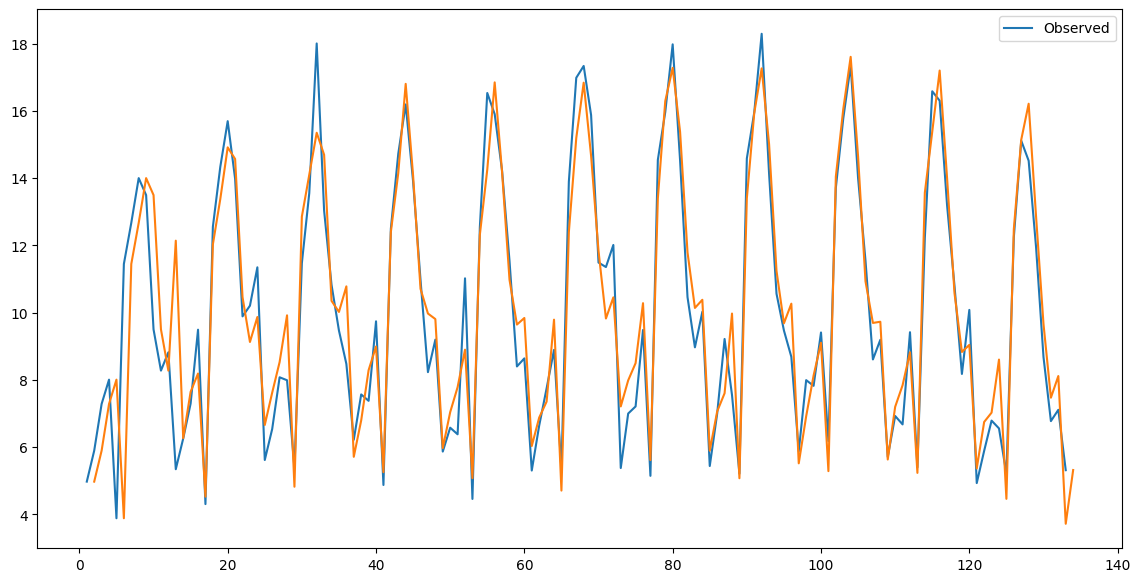

In [15]:
# Применяем лучшую модель к данным региона North
best_order = (0, 1, 1)
best_seasonal_order = (0, 1, 1, 12)
model = SARIMAX(df['north'], order=best_order, seasonal_order=best_seasonal_order, enforce_stationarity=False, enforce_invertibility=False)
results = model.fit()

# Выводим результаты применения модели
print(results.summary())

# Прогнозирование
forecast = results.get_prediction(start=df.index[0], end=df.index[-1], dynamic=False)
confidence_intervals = forecast.conf_int()

# График
df['north'].plot(label='Observed', figsize=(14, 7))
plt.plot(forecast.predicted_mean)
# plt.fill_between(x = df.index,  y1 = confidence_intervals.iloc[:, 0], y2 = confidence_intervals.iloc[:, 1], color='k', alpha=.25)


plt.legend()
plt.show()

In [16]:
# Применяем лучшую модель к данным региона North
best_order = (0, 1, 1)
best_seasonal_order = (0, 1, 1, 12)
model = SARIMAX(df['north'], order=best_order, seasonal_order=best_seasonal_order, enforce_stationarity=False, enforce_invertibility=False)
results = model.fit()

# Выводим результаты применения модели
# print(results.summary())

# Прогнозирование
forecast = results.get_forecast(steps=12) # Прогнозируем на 12 шагов вперед
forecast_index = forecast.index# Генерируем индексы для прогнозных значений
# print(forecast_index)
# forecast_mean = forecast.predicted_mean
# print(forecast_mean)

# forecast_conf_int = forecast.conf_int()

# # График
# plt.figure(figsize=(14, 7))
# plt.plot(df.index, df['north'], label='Observed')
# plt.plot(forecast_index, forecast_mean, label='Forecast')
# plt.fill_between(forecast_index, forecast_conf_int.iloc[:, 0], forecast_conf_int.iloc[:, 1], color='k', alpha=.25)
# plt.xlabel('Date')
# plt.ylabel('Values')
# plt.title('Forecast for North Region')
# plt.legend()
# plt.show()

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.20367D+00    |proj g|=  2.14472D-01

At iterate    5    f=  1.15494D+00    |proj g|=  1.36755D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      6      9      1     0     0   1.565D-06   1.155D+00
  F =   1.1549354760756172     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


 This problem is unconstrained.


In [17]:
forecast

In [18]:
df['north']

1       4.977
2       5.898
3       7.287
4       8.009
5       3.888
        ...  
129    11.942
130     8.682
131     6.776
132     7.112
133     5.317
Name: north, Length: 133, dtype: float64